In [22]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import pandas as pd
import cmcrameri as cmcm
import juanfit

In [23]:
sumer_list_excel = pd.read_excel("../../save/sumer_line_list_final_v2.xlsx")
sumer_list_excel["ion"] = sumer_list_excel["ion"].str.strip()
sumer_list_excel["charge_stat"] = sumer_list_excel["charge_stat"].str.strip()
sumer_list_excel["quality"] = sumer_list_excel["quality"].str.strip()
sumer_list_excel["fwhm_true_err"] = sumer_list_excel["fwhm_fit"]/sumer_list_excel["fwhm_true"]*sumer_list_excel["fwhm_err"]
sumer_list_excel

,ion,charge_stat,Z,A,temp,wvl_fit,wvl_chianti,fwhm_fit,fwhm_err,fwhm_true,fwhm_awsom,quality,fwhm_true_err
0,Fe,xi,10,55.85000,6.0,680.439,680.406,0.3450,0.0280,0.28048,0.172,b,0.034441
1,Na,ix,8,22.98977,5.9,681.759,681.719,0.3080,0.0053,0.23251,0.175,a,0.007021
2,Mg,viii,7,24.31000,5.9,689.629,689.641,0.2760,0.0180,0.18700,0.170,a,0.026567
3,Ca,ix,8,40.08000,5.8,691.445,691.424,0.3280,0.0170,0.25933,0.159,b,0.021502
4,Si,ix,8,28.08550,5.9,694.738,694.686,0.2490,0.0130,0.14180,0.185,a,0.022828
5,Fe,viii,7,55.85000,5.8,697.155,697.156,0.2810,0.0210,0.19474,0.154,a,0.030302
6,Al,ix,8,26.98154,5.9,703.592,703.730,0.2560,0.0860,0.15402,0.185,b,0.142942
7,Mg,ix,8,24.31000,5.9,706.077,706.060,0.3050,0.0035,0.22850,0.183,a,0.004672
8,Ar,viii,7,39.94800,5.7,713.784,713.801,0.2830,0.0150,0.19754,0.166,a,0.021489
9,Mg,ix,8,24.31000,5.9,749.525,749.552,0.3012,0.0093,0.22327,0.195,a,0.012546


In [24]:
c = const.c.cgs/1.e5

In [25]:
def aver_err(data,err,thresh=1.e-5,iter_max=1000):
    sigma_sq = np.var(data)
    n_data = len(data)

    if type(data) is list:
        data = np.array(data)
    if type(err) is list:
        err = np.array(err)

    err_sq_mean = np.mean(np.square(err)) 
    for ii in range(iter_max):
        weight = 1./(sigma_sq + err**2)
        weight = weight/np.sum(weight)
        aver_new = np.sum(weight*data)
        sigma_new_sq = np.max([0.,n_data/(n_data - 1.)*np.sum(weight*np.square(data-aver_new)) - \
                                err_sq_mean])
        
        #print(aver_new,sigma_new_sq)
        if ((sigma_new_sq <= sigma_sq*(1+thresh)) and (sigma_sq <= sigma_new_sq*(1+thresh))):
            break
        else:
            sigma_sq = sigma_new_sq
        
    # if sigma_new_sq == 0:
    #     print("sigma_new is 0.")

    sigma_tot = np.sqrt(1./np.sum(1./(sigma_new_sq + err**2)))
    return aver_new, sigma_tot, sigma_new_sq

def plot_eis_awsom_width(df,ion,charge=None,quality="a",plot_awsom=True,plot_mle=False,print_df=True,
                        print_veff=False,save_fig=False,save_fname=None,bootstrap=True):
    c = const.c.cgs/1.e5

    if type(ion) is str:
        ion = [ion]
    if type(charge) is str:
        charge = [charge]
    if type(quality) is str:
        quality = [quality]
    
    if charge is None:
        df_plot = df[(df["ion"].isin(ion)) & (df["quality"].isin(quality))].copy()
    else:
        df_plot = df[(df["ion"].isin(ion)) & (df["charge_stat"].isin(charge)) \
                    & (df["quality"].isin(quality))].copy()

    line_name = df_plot["ion"] + r" \textsc{"+ df_plot["charge_stat"] + r"} " + \
         ((df_plot["wvl_chianti"].values).astype("int")).astype("str")

    eis_veff = df_plot["fwhm_true"]/df_plot["wvl_chianti"]*c/np.sqrt(4*np.log(2))

    awsom_veff = df_plot["fwhm_awsom"]/df_plot["wvl_chianti"]*c/np.sqrt(4*np.log(2))

    eis_veff_err = df_plot["fwhm_err"]*df_plot["fwhm_fit"] \
                    /df_plot["fwhm_true"]/df_plot["wvl_chianti"]*c/np.sqrt(4*np.log(2))

    df_plot["eis_veff"] = eis_veff
    df_plot["awsom_veff"] = awsom_veff
    df_plot["eis_veff_err"] = eis_veff_err

    n_lines = len(df_plot.index)
    plot_x = np.arange(n_lines)

    fig, ax = plt.subplots(figsize=(n_lines*1.2+2,6),constrained_layout=True)

    if plot_mle is True:
        best_est,err_tot, err_est_sq = aver_err(eis_veff,eis_veff_err)
        best_low1sig,best_up1sig = best_est - err_tot, best_est + err_tot
        best_low3sig,best_up3sig = best_est - 3*err_tot, best_est + 3*err_tot
        aver_bootstrap = np.zeros(10000)
        if bootstrap is True:
            for ii in range(10000):
                data = np.random.normal(best_est,np.sqrt(err_est_sq),len(eis_veff))
                epsilon = np.random.normal(0,eis_veff_err)
                data_gen = data + epsilon
                aver_bootstrap[ii], _, _ = aver_err(data_gen,eis_veff_err) 
            best_low3sig,best_low1sig,best_est,best_up1sig,best_up1sigbest_up3sig = \
                np.percentile(aver_bootstrap,[0.15,16,50,84,99.85])



        ax.axhspan(best_low1sig,best_up1sig,color="#FAD689",alpha=0.9)
        ax.axhspan(best_low3sig,best_up3sig,color="#FAD689",alpha=0.5)
        ax.axhline(best_est,color="#FFB11B",lw=2,ls="--",label=r"$\bar{v}_{\rm eff}$")
    
    if plot_awsom:    
        ax.scatter(plot_x,awsom_veff,color="#0089A7",marker="d",
                    lw=3,label="AWSoM",zorder=15)
    ax.errorbar(plot_x,eis_veff,eis_veff_err,color="#CC543A",ls="none",marker="o",
                markersize=6,capsize=5,lw=2,label="SUMER",zorder=15)


    # ax.scatter(plot_x,awsom_veff,color="#0089A7",marker="o",
    #             lw=3,label="AWSoM",zorder=14)


    ax.set_xlim(left=-1,right=len(line_name))
    ax.set_xticks(plot_x)
    ax.set_xticklabels(line_name)
    ax.tick_params(labelsize=16)
    ax.set_xlabel("Line",fontsize=16)
    ax.set_ylabel(r"Effective Velocity $v_{\rm eff}\ \left[\mathrm{km \cdot s^{-1}} \right]$",
                    fontsize=16)

    if charge is not None:
        title = r"\textbf{" + ion[0] + ' '.join([r" \textsc{" + charge_ +r"} " for charge_ in charge]) + \
                r"}"
    else:
        title = r"\textbf{" + ion[0] + r"}"

    if (plot_mle is True) and (bootstrap is False):
        title = title + r" $\bar{{v}}_{{\rm eff}} = {{{:.1f}}}\pm{{{:.1f}}}\ \left[\mathrm{{km \cdot s^{{-1}}}}\right]$".format(best_est,err_tot)
    elif (plot_mle is True) and (bootstrap is True):
        title = title + \
        r" $\bar{{v}}_{{\rm eff}} = {{{:.1f}}}_{{-{:.1f}}}^{{+{:.1f}}}\ \left[\mathrm{{km \cdot s^{{-1}}}}\right]$". \
            format(best_est,best_est-best_low1sig,best_up1sig-best_est)
    ax.set_title(title,fontsize=18,pad=10)
    ax.tick_params(which="major",width=1.2,length=8,direction="in")
    ax.tick_params(which="minor",width=1.2,length=4,direction="in")
    ax.grid("on")
    ax.legend(loc = 'lower left',fontsize = 18,frameon=False,handlelength=1)

    if print_df:
        print(df_plot)

    if print_veff:
        print(eis_veff)
        print(eis_veff_err)
    
    if save_fig:
        plt.savefig(fname=save_fname,format=save_fname[-3:])

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
2   Mg        viii  7  24.31   5.9  689.629      689.641    0.2760    0.0180   
10  Mg        viii  7  24.31   5.8  762.647      762.660    0.2580    0.0240   
13  Mg        viii  7  24.31   5.8  772.302      772.260    0.2802    0.0086   
16  Mg        viii  7  24.31   5.8  782.420      782.362    0.2984    0.0058   

    fwhm_true  fwhm_awsom quality  fwhm_true_err   eis_veff  awsom_veff  \
2     0.18700       0.170       a       0.026567  48.819858   44.381689   
10    0.16138       0.187       a       0.038369  38.097521   44.145721   
13    0.19722       0.189       a       0.012218  45.979621   44.063221   
16    0.22304       0.191       a       0.007760  51.327840   43.954525   

    eis_veff_err  
2       6.935773  
10      9.057915  
13      2.848591  
16      1.785724  


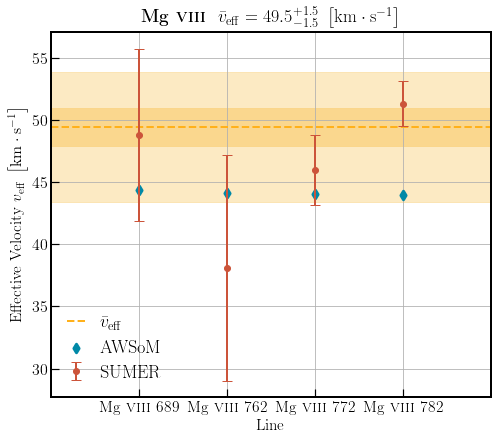

In [26]:
plot_eis_awsom_width(sumer_list_excel,"Mg",charge="viii",plot_mle=True,print_df=True)

  ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
7  Mg          ix  8  24.31   5.9  706.077      706.060    0.3050    0.0035   
9  Mg          ix  8  24.31   5.9  749.525      749.552    0.3012    0.0093   

   fwhm_true  fwhm_awsom quality  fwhm_true_err   eis_veff  awsom_veff  \
7    0.22850       0.183       a       0.004672  58.266989   46.664590   
9    0.22327       0.195       a       0.012546  53.629850   46.839346   

   eis_veff_err  
7      1.191292  
9      3.013587  


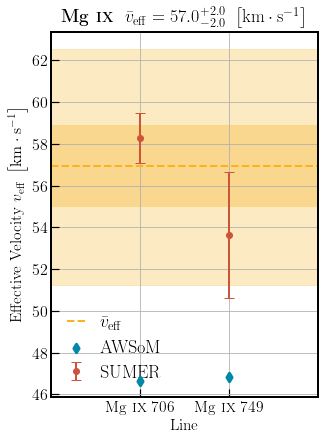

In [27]:
plot_eis_awsom_width(sumer_list_excel,"Mg",charge="ix",plot_mle=True)

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
23  Mg           x  9  24.31   6.0  609.800      609.793    0.1714    0.0022   
24  Mg           x  9  24.31   6.0  624.955      624.941    0.1933    0.0030   

    fwhm_true  fwhm_awsom quality  fwhm_true_err   eis_veff  awsom_veff  \
23    0.14516       0.174       a       0.002598  42.859046   51.374167   
24    0.17058       0.175       a       0.003400  49.143611   50.417001   

    eis_veff_err  
23      0.766977  
24      0.979409  


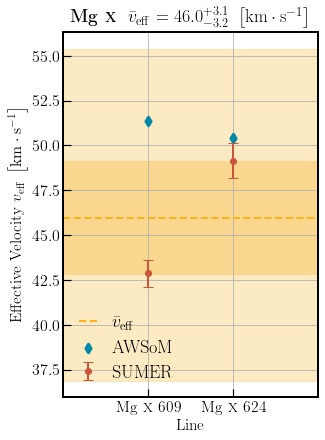

In [28]:
plot_eis_awsom_width(sumer_list_excel,"Mg",charge="x",plot_mle=True)

  ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
5  Fe        viii  7  55.85   5.8  697.155      697.156     0.281     0.021   

   fwhm_true  fwhm_awsom quality  fwhm_true_err   eis_veff  awsom_veff  \
5    0.19474       0.154       a       0.030302  50.292494   39.771203   

   eis_veff_err  
5      7.825615  


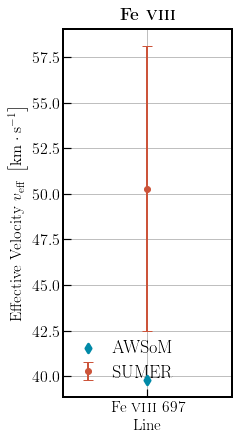

In [29]:
plot_eis_awsom_width(sumer_list_excel,"Fe",charge="viii",print_df=True)

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
17  Fe           x  9  55.85   5.9  1028.04     1028.053     0.355     0.011   

    fwhm_true  fwhm_awsom quality  fwhm_true_err   eis_veff  awsom_veff  \
17    0.30064       0.253       a       0.012989  52.651316   44.308086   

    eis_veff_err  
17      2.274766  


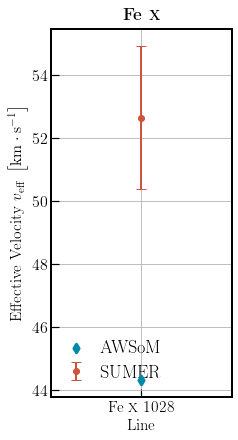

In [30]:
plot_eis_awsom_width(sumer_list_excel,"Fe",charge="x",print_df=True)

   ion charge_stat   Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
18  Fe          xi  10  55.85   6.0  1028.99     1028.955     0.322      0.03   

    fwhm_true  fwhm_awsom quality  fwhm_true_err   eis_veff  awsom_veff  \
18     0.2599       0.287       a       0.037168  45.476588   50.218472   

    eis_veff_err  
18      6.503579  


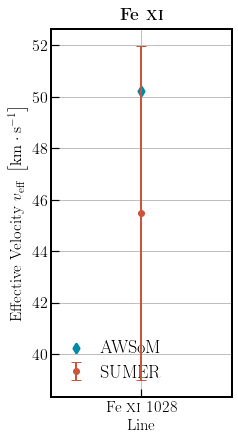

In [31]:
plot_eis_awsom_width(sumer_list_excel,ion="Fe",charge="xi",print_df=True)

  ion charge_stat  Z         A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
1  Na          ix  8  22.98977   5.9  681.759      681.719     0.308   

   fwhm_err  fwhm_true  fwhm_awsom quality  fwhm_true_err   eis_veff  \
1    0.0053    0.23251       0.175       a       0.007021  61.406482   

   awsom_veff  eis_veff_err  
1   46.217945      1.854204  


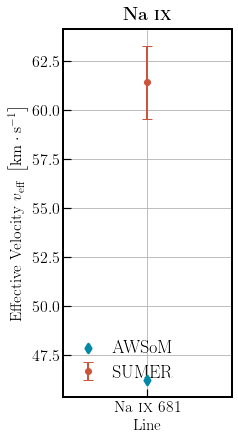

In [32]:
plot_eis_awsom_width(sumer_list_excel,"Na",charge="ix",print_df=True)

  ion charge_stat  Z       A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
8  Ar        viii  7  39.948   5.7  713.784      713.801     0.283     0.015   

   fwhm_true  fwhm_awsom quality  fwhm_true_err   eis_veff  awsom_veff  \
8    0.19754       0.166       a       0.021489  49.825983   41.870574   

   eis_veff_err  
8      5.420302  


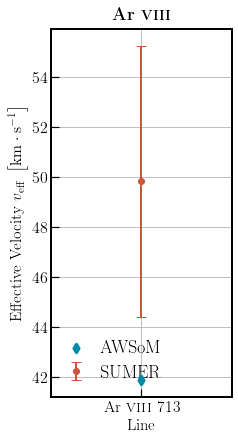

In [33]:
plot_eis_awsom_width(sumer_list_excel,"Ar","viii",print_df=True)

   ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
19   O          vi  5  15.9994   5.8  1031.92     1031.912    0.3480   
20   O          vi  5  15.9994   5.8  1037.62     1037.613    0.3456   

    fwhm_err  fwhm_true  fwhm_awsom quality  fwhm_true_err   eis_veff  \
19    0.0029    0.28829       0.269       a       0.003501  50.299642   
20    0.0010    0.28880       0.270       a       0.001197  50.111772   

    awsom_veff  eis_veff_err  
19   46.934003      0.610777  
20   46.849648      0.207644  


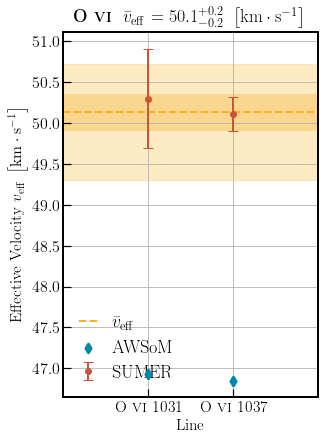

In [34]:
plot_eis_awsom_width(sumer_list_excel,"O","vi",plot_mle=True)

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
14   S           x  9  32.06   6.0  776.242      776.373     0.358     0.054   

    fwhm_true  fwhm_awsom quality  fwhm_true_err   eis_veff  awsom_veff  \
14    0.29939       0.235       a       0.064571  69.429629   54.497354   

    eis_veff_err  
14     14.974318  


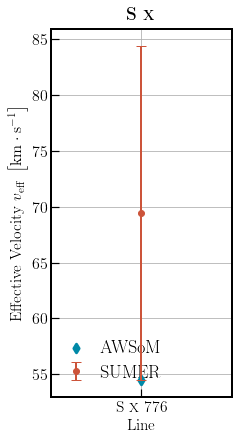

In [35]:
plot_eis_awsom_width(sumer_list_excel,"S","x",print_df=True)

   ion charge_stat  Z       A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
12  Ne        viii  7  20.179   5.8  770.426      770.428    0.3023    0.0017   
15  Ne        viii  7  20.179   5.8  780.380      780.385    0.3110    0.0030   

    fwhm_true  fwhm_awsom quality  fwhm_true_err   eis_veff  awsom_veff  \
12    0.22818       0.191       a       0.002252  53.324095   44.635385   
15    0.23980       0.193       a       0.003891  55.324595   44.527301   

    eis_veff_err  
12      0.526327  
15      0.897639  


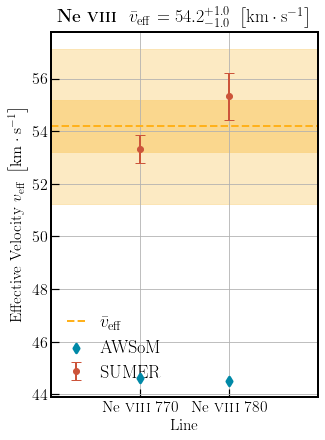

In [36]:
plot_eis_awsom_width(sumer_list_excel,"Ne","viii",plot_mle=True)

   ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
21  Si         vii  6  28.0855   5.8  1049.28     1049.153     0.351   

    fwhm_err  fwhm_true  fwhm_awsom quality  fwhm_true_err   eis_veff  \
21     0.019    0.29593       0.245       a       0.022536  50.784145   

    awsom_veff  eis_veff_err  
21   42.044117      3.867327  


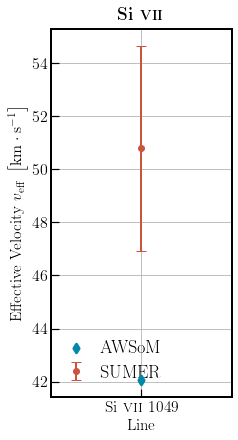

In [37]:
plot_eis_awsom_width(sumer_list_excel,"Si","vii",print_df=True)

  ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
4  Si          ix  8  28.0855   5.9  694.738      694.686     0.249     0.013   

   fwhm_true  fwhm_awsom quality  fwhm_true_err   eis_veff  awsom_veff  \
4     0.1418       0.185       a       0.022828  36.750704   47.946969   

   eis_veff_err  
4      5.916378  


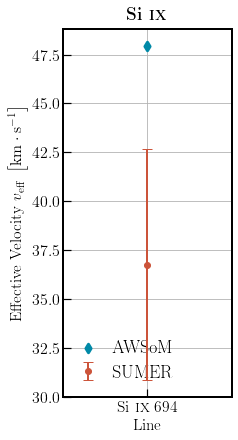

In [38]:
plot_eis_awsom_width(sumer_list_excel,"Si","ix",print_df=True)

  ion charge_stat  Z         A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
6  Al          ix  8  26.98154   5.9  703.592       703.73     0.256   

   fwhm_err  fwhm_true  fwhm_awsom quality  fwhm_true_err   eis_veff  \
6     0.086    0.15402       0.185       b       0.142942  39.404791   

   awsom_veff  eis_veff_err  
6   47.330778     36.570695  


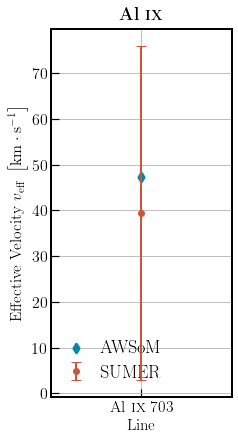

In [39]:
plot_eis_awsom_width(sumer_list_excel,"Al","ix",quality=["a","b"],print_df=True)

   ion charge_stat  Z         A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
22  Al         vii  6  26.98154   5.8  1053.86     1053.996     0.308   

    fwhm_err  fwhm_true  fwhm_awsom quality  fwhm_true_err  eis_veff  \
22     0.034    0.24488       0.247       a       0.042764  41.83043   

    awsom_veff  eis_veff_err  
22   42.192569      7.304918  


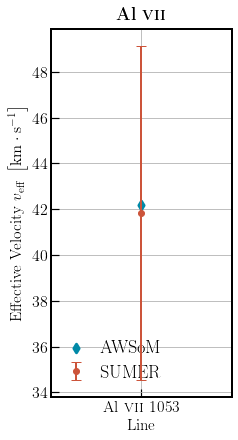

In [40]:
plot_eis_awsom_width(sumer_list_excel,"Al","vii",quality=["a","b"],print_df=True)

   ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
25  Si           x  9  28.0855   6.0   624.72      624.694     0.145   

    fwhm_err  fwhm_true  fwhm_awsom quality  fwhm_true_err   eis_veff  \
25      0.02    0.11184       0.262       b        0.02593  32.233525   

    awsom_veff  eis_veff_err  
25   75.511298      7.473284  


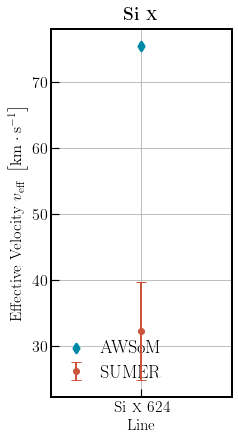

In [41]:
plot_eis_awsom_width(sumer_list_excel,"Si","x",quality=["a","b"],print_df=True)